Welcome! Below we will investigate how click-through rate (CTR) relates to other key metrics for a YouTube channel. This is meant to discover how important CTR is for viewership, video success, and channel success in general. 

Below we will:
1. Collect and clean data
2. Perform a linear regression (statistical tool to try and see correlation and maybe causation)
3. Investigate and visualize our results


DATA

The YouTube API provides a lot of valuable data on all YouTube channels and videos. However, YouTube does not openly publish CTR data. Only creators have access to that. Luckly one creator posted her YouTube channel statistics to kaggle, and we will use these for this analysis.

Data from: https://www.kaggle.com/datasets/kristhecoder/youtube-revenue-data-20182021?select=Table+data+2020.csv

Ideally we could look at all YouTube channels, but for this experiment we are limited to this one. Our data will be biased towards this specific channel. We unfortunately do not know which channel this is, but we can replicate this process with any YouTuber who shares their data with me :)

In [175]:
import pandas as pd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set_theme(style="darkgrid")
import warnings

warnings.filterwarnings("ignore")

#Load data

df = pd.read_csv("data/Table data 2020.csv")
#Remove summary row for analysis
df = df.drop(0)
df = df.drop(len(df))

#Turn Av­er­age view dur­a­tion into a minute count number

df[['Hours AVD', 'Minutes AVD', 'Seconds AVD']] = df['Av­er­age view dur­a­tion'].str.split(':', expand=True)
df['AVD'] = df['Hours AVD'].astype(int)*60 + df['Minutes AVD'].astype(int) + (df['Seconds AVD'].astype(int)/60)
df = df.drop(['Hours AVD', 'Minutes AVD', 'Seconds AVD','Av­er­age view dur­a­tion'], axis=1)

#Rename CTR
df = df.rename(columns={'Im­pres­sions click-through rate (%)':'CTR', 'Your es­tim­ated rev­en­ue (USD)':'Revenue', 
                        'Im­pres­sions':'Impressions', 'Videos pub­lished':'Videos_published',
                       'Av­er­age per­cent­age viewed (%)':'APV',
                       'Av­er­age views per view­er':'Average_views_per_viewer',
                       'Unique view­ers':'Unique_viewers', 'Com­ments ad­ded':'Comments_added',
                       'Likes (vs. dis­likes) (%)':'Likes_vs._dislikes_%',
                       'Sub­scribers':'Subscribers'})

Below are summary statistics for the data we have. Important notes:
1. This data is from May 2020 - Sept 2021
2. This creator published 80 videos in this dataset
3. During this time the channel grew significantly by most metrics (Impressions, CTR, unique viewers, subscribers, likes, etc.)


In [176]:

print('Total Videos Published:')
print(df['Videos_published'].sum())

print('Other summary statistics:')
df.describe()

Total Videos Published:
80.0
Other summary statistics:


,Average_views_per_viewer,Unique_viewers,CTR,Impressions,Comments_added,Shares,Likes_vs._dislikes_%,Dis­likes,Sub­scribers lost,Sub­scribers gained,Likes,APV,Videos_published,Videos ad­ded,Subscribers,Views,Watch time (hours),Revenue,AVD
count,500.000000,500.000000,500.000000,5.000000e+02,500.000000,500.00000,500.00000,500.00000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.881840,53787.126000,5.143760,1.829573e+06,481.324000,265.48200,98.10418,84.16000,298.896000,1372.612000,6117.344000,31.339220,0.160000,0.228000,1073.716000,112029.986000,8603.532365,42.204774,3.918800
std,0.294160,73201.877638,0.820052,2.492488e+06,1051.289613,464.80275,0.77030,106.65158,395.532463,1783.041895,10317.470393,5.642515,0.372394,0.540926,1413.711809,153411.108224,12462.521210,63.298060,0.736809
min,1.444800,2184.000000,3.520000,4.748200e+04,12.000000,9.00000,95.22000,0.00000,12.000000,105.000000,174.000000,12.340000,0.000000,0.000000,67.000000,3617.000000,177.300600,0.767000,2.783333
25%,1.625725,5942.500000,4.610000,1.234040e+05,48.000000,42.00000,97.68000,10.75000,60.000000,268.750000,480.750000,26.390000,0.000000,0.000000,219.000000,9615.500000,519.049725,2.650500,3.212500
50%,1.828000,22398.500000,5.035000,5.576205e+05,140.500000,103.00000,98.23000,36.00000,113.500000,569.500000,1747.500000,31.210000,0.000000,0.000000,454.500000,36198.500000,2274.322300,10.790000,3.858333
75%,2.103450,78916.000000,5.810000,2.925336e+06,464.750000,312.75000,98.62000,125.25000,327.250000,1903.750000,7915.750000,34.885000,0.000000,0.000000,1526.750000,176122.000000,13615.801675,62.730000,4.466667
max,2.615800,482254.000000,7.560000,1.632350e+07,11582.000000,6513.00000,100.00000,664.00000,2177.000000,12474.000000,63543.000000,48.460000,2.000000,4.000000,10297.000000,954121.000000,73470.409300,397.066000,6.583333


The data is ready for our statistical analysis. 

For this project we want to know if CTR is strongly coorelated with success. To do that we can perform a linear regression with our data choosing a variable to represent success.
Each regression will give us an idea of how much CTR matters.

First we can use estimated revenue as our variable for success.



In [177]:
def chart_relationship(x_var, y_var):
    colors = ["#00acd2", "#e14377"]
    sns.set_palette(sns.color_palette(colors))
    chart = sns.scatterplot(data=df,x=x_var, y=y_var)#.set(title=x_var + ' Relation to ' + y_var, fontdict={'size':30});

    model2 = LinearRegression()
    X = df[[x_var]]
    y = df[[y_var]]
    model2.fit(X, y)

    plt.plot([df[x_var].min(), df[x_var].max()], 
    [int(model2.predict(np.array(df[x_var].min()).reshape(-1,1))[0][0]), model2.predict(np.array(df[x_var].max()).reshape(-1,1))[0][0]], color=colors[1])

    plt.savefig(x_var + '_relation_to ' + y_var + ".png", bbox_inches='tight')
    return model2

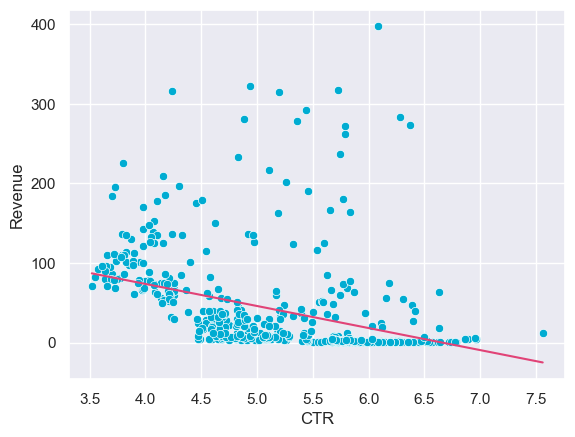

In [178]:

x_var = 'CTR'
y_var = 'Revenue'
model = chart_relationship(x_var,y_var)



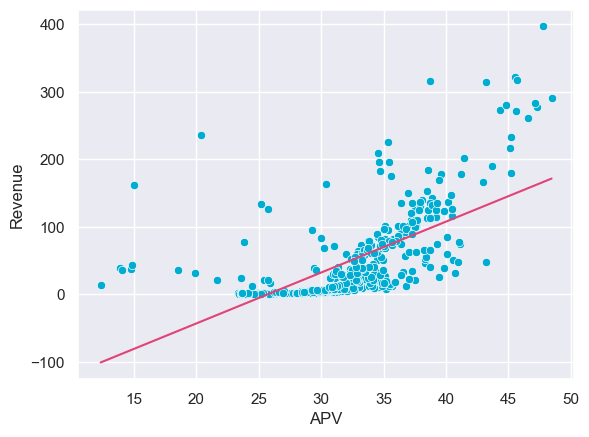

In [179]:

x_var = 'APV'
y_var = 'Revenue'
model = chart_relationship(x_var,y_var)


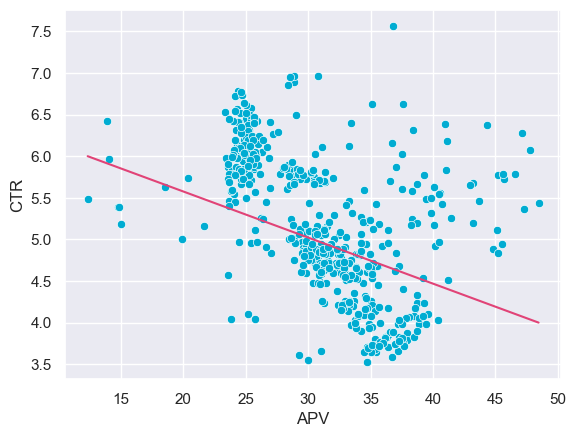

In [180]:
x_var = 'APV'
y_var = 'CTR'
model = chart_relationship(x_var,y_var)

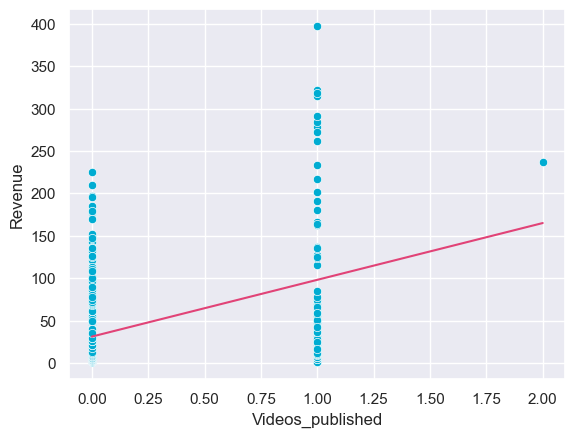

In [181]:
x_var = 'Videos_published'
y_var = 'Revenue'
model = chart_relationship(x_var,y_var)

In [182]:
# Import Package
import statsmodels.api as sm
from statsmodels.api import add_constant

# Build Model
X = df[['Average_views_per_viewer',  'Unique_viewers', 'CTR', 'Impressions', 'Comments_added', 'Shares', 'Likes', 'APV', 'Videos_published', 'Subscribers', 'Views']]
y = df[['Revenue']]
X = sm.add_constant(X)
model = sm.RLM(y,X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                Revenue   No. Observations:                  500
Model:                            RLM   Df Residuals:                      488
Method:                          IRLS   Df Model:                           11
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 07 Feb 2023                                         
Time:                        16:26:55                                         
No. Iterations:                    50                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -36.6937      3.514    -10.442      0.000     -43.581     -29.806
Average_views_per_viewer     5.0096      1.216      4.119      0.000       2.626       7.393
Unique_viewers               0.0006   4.13e-05     14.289      0.000       0.001       0.001
CTR                          2.2952      0.346      6.631      0.000       1.617       2.974
Impressions               1.266e-05   8.78e-07     14.412      0.000    1.09e-05    1.44e-05
Comments_added               0.0042      0.001      7.251      0.000       0.003       0.005
Shares                      -0.0065      0.001     -9.184      0.000      -0.008      -0.005
Likes                        0.0017      0.000      9.735      0.000       0.001       0.002
APV                          0.5328      0.046     11.607      0.000       0.443       0.623
Videos_published            -4.5745      0.627     -7.293      0.000      -5.804      -3.345
Subscribers                 -0.0108      0.001    -19.243      0.000      -0.012      -0.010
Views                       -0.0001   3.28e-05     -3.650      0.000      -0.000   -5.54e-05
============================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

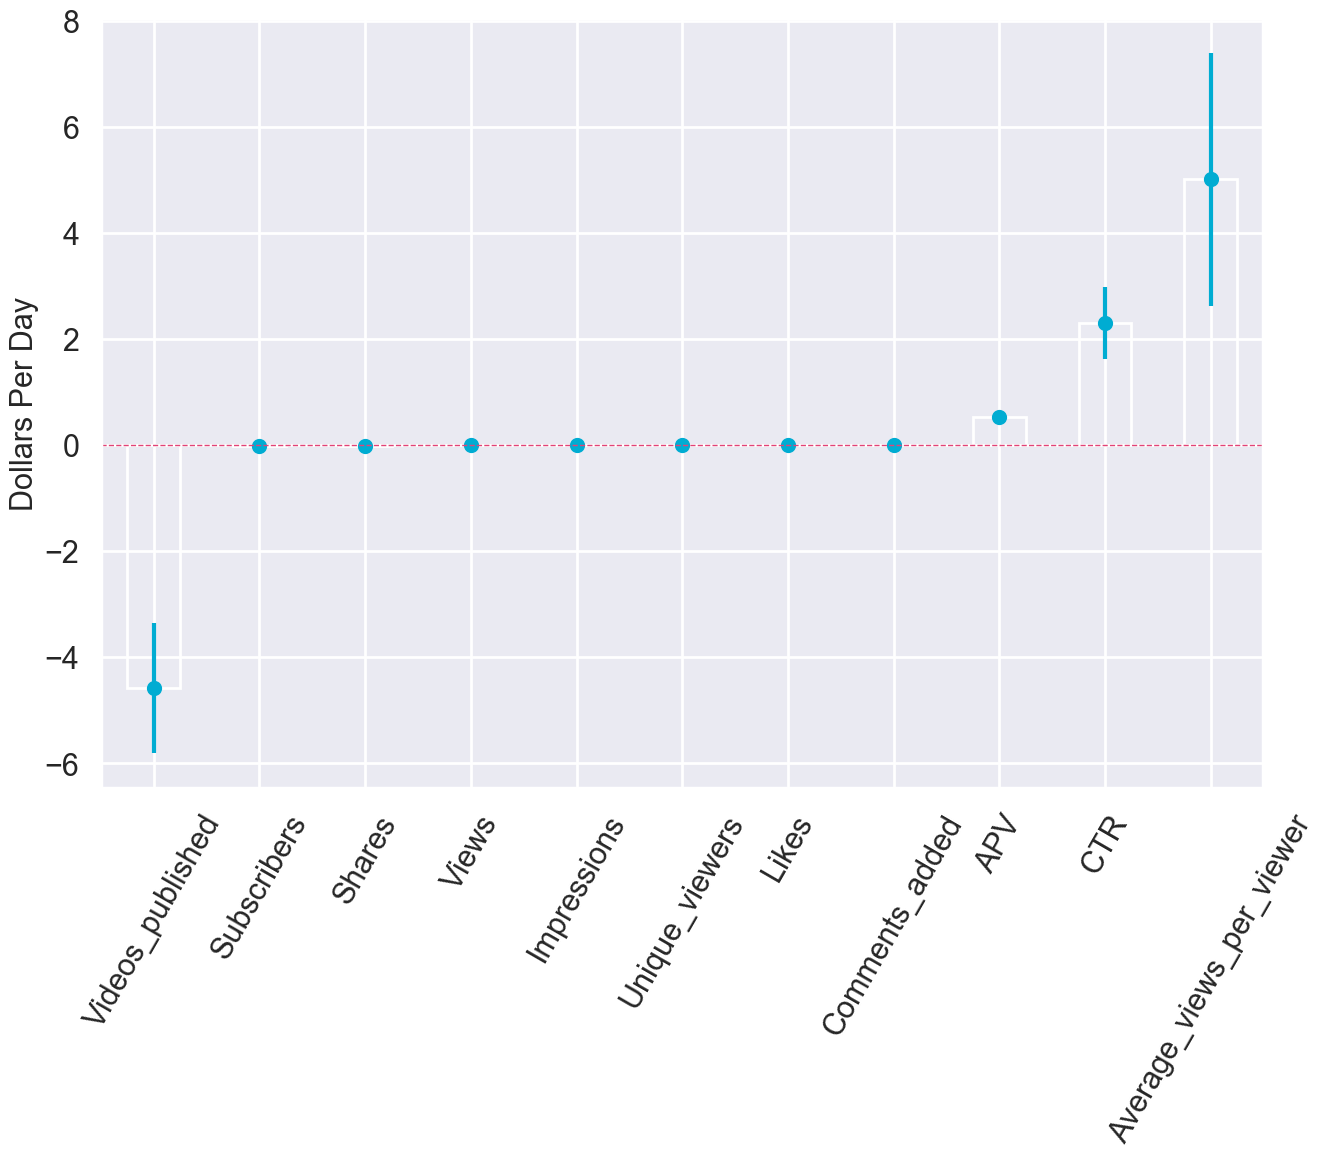

In [184]:

coef_df = pd.DataFrame(results.summary().tables[1].data)
coef_df
colors = ["#00acd2", "#e14377"]
# Add column names
coef_df.columns = coef_df.iloc[0]

# Drop the extra row with column labels
coef_df=coef_df.drop(0)

# Set index to variable names 
coef_df = coef_df.set_index(coef_df.columns[0])

# Change datatype from object to float
coef_df = coef_df.astype(float)

# Get errors; (coef - lower bound of conf interval)
errors = coef_df['coef'] - coef_df['[0.025']
for x in range(len(errors)):
    if errors[x] < 0:
        errors[x] = 0
# Append errors column to dataframe
coef_df['errors'] = errors

# Drop the constant for plotting
coef_df = coef_df.drop(['const'])

# Sort values by coef ascending
coef_df = coef_df.sort_values(by=['coef'])

### Plot Coefficients ###

# x-labels
variables = list(coef_df.index.values)

# Add variables column to dataframe
coef_df['variables'] = variables

# Set sns plot style back to 'poster'
# This will make bars wide on plot
sns.set_context("poster")

# Define figure, axes, and plot
fig, ax = plt.subplots(figsize=(15, 10))
len(errors)
# Error bars for 95% confidence interval
# Can increase capsize to add whiskers
coef_df.plot(x='variables', y='coef', kind='bar',
        ax=ax, color='none', fontsize=22, 
        ecolor=colors[0],capsize=0,
        yerr='errors', legend=False)

# Set title & labels
#plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
ax.set_ylabel('Dollars Per Day',fontsize=22)
ax.set_xlabel('',fontsize=22)
# Line to define zero on the y-axis
ax.axhline(y=0, linestyle='--', color=colors[1], linewidth=1)
# Coefficients
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
    marker='o', s=80, 
    y=coef_df['coef'], color=colors[0])


plt.xticks(rotation=60)
#plt.show()
plt.savefig("coefficients_of_features.png", bbox_inches='tight')